<center><h1>Panorama Task 2nd Trial</h1><center>

### Set up Environment and Import Libraries

In [1]:
# Import necessary libraries
import numpy as np  # NumPy is used for numerical operations on arrays
import cv2  # OpenCV is a computer vision library
import matplotlib.pyplot as plt # Importing the matplotlib library for plotting

### Display Images with Matplotlib and OpenCV

In [2]:
def plt_show(images):
    # If there's only one image, handle it differently
    if len(images) == 1:
        plt.figure(figsize=(10, 10))  # Set the figure size
        rgb_frame = cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_frame)
        plt.axis('off')
        plt.show()
    else:
        # Create a subplot with 1 row and len(images) columns, set the figure size
        fig, axes = plt.subplots(1, len(images), figsize=(10, 5))

        # Iterate through the images and corresponding axes
        for i, (image, ax) in enumerate(zip(images, axes)):
            # Convert the BGR image to RGB
            rgb_frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Display the image on the current axis
            ax.imshow(rgb_frame)

            # Turn off axis labels
            ax.axis('off')

        # Display the plot with all the images
        plt.show()

### Load and Display Images with Matplotlib and OpenCV

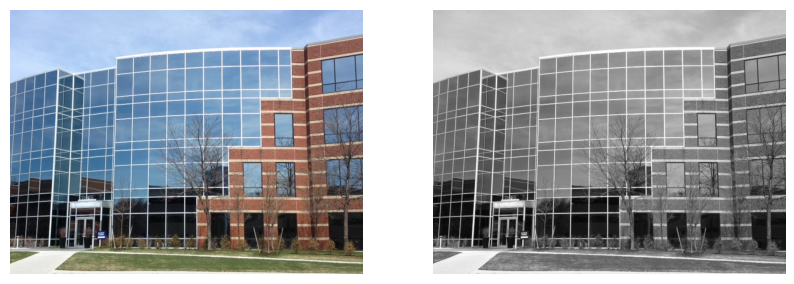

In [3]:
# Read the color image from file
img_ = cv2.imread('image2.png')

# Convert the color image to grayscale
img1 = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)

# Display both the color and grayscale images using plt_show
plt_show([img_, img1])


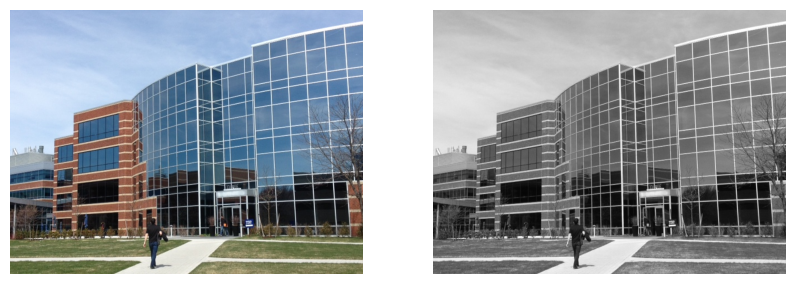

In [4]:
# Read the color image from file
img = cv2.imread('image1.png')

# Convert the color image to grayscale
img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Display both the color and grayscale images using plt_show
plt_show([img, img2])

### SIFT Keypoint Detection and Visualization

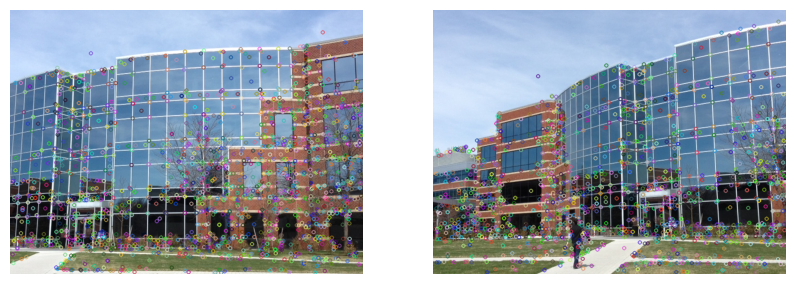

In [5]:
# Create a SIFT object
sift = cv2.SIFT_create()

# Find keypoints and compute descriptors for the first image (img1)
kp1, des1 = sift.detectAndCompute(img1, None)

# Find keypoints and compute descriptors for the second image (img2)
kp2, des2 = sift.detectAndCompute(img2, None)

# Display the original color images with keypoints marked
# using OpenCV's drawKeypoints and plt_show function
plt_show([cv2.drawKeypoints(img_, kp1, None), cv2.drawKeypoints(img, kp2, None)])

### Matching 2 Images Using BF and Flann

In [6]:
# Use the FlannBasedMatcher to find k best matches
match = cv2.FlannBasedMatcher(dict(algorithm = 0, trees = 5), dict(checks = 50))
matches = match.knnMatch(des1,des2,k=2)

# Set parameters for drawing matches
draw_parameters = dict(matchColor=(0, 255, 0),
                       singlePointColor=None,
                       flags=2)

In [7]:
# Use the BFMatcher to find k best matches
match = cv2.BFMatcher()
matches = match.knnMatch(des1,des2,k=2)


In [8]:
# Create an empty list to store good matches
good = []

# Iterate through the matches
for m, n in matches:
    # Check if the distance ratio between the best match (m) and the second best match (n) is below a threshold (0.3)
    if m.distance < 0.3 * n.distance:
        # If the condition is met, consider it a good match and add it to the list
        good.append(m)

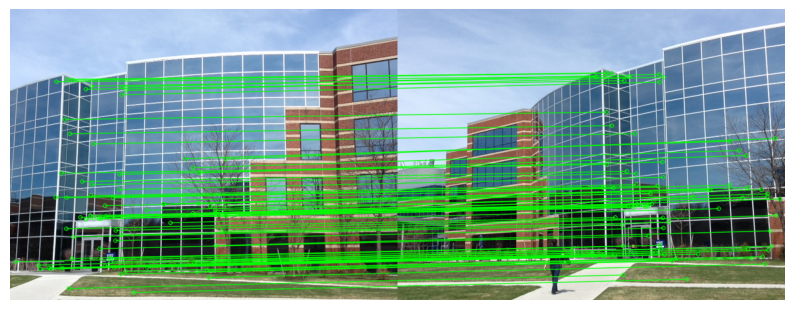

In [9]:
# Draw matches on a new image
img3 = cv2.drawMatches(img_, kp1, img, kp2, good, None, **draw_parameters)

# Display the image with drawn matches
plt_show([img3])

### Image Matching and Perspective Transformation with RANSAC

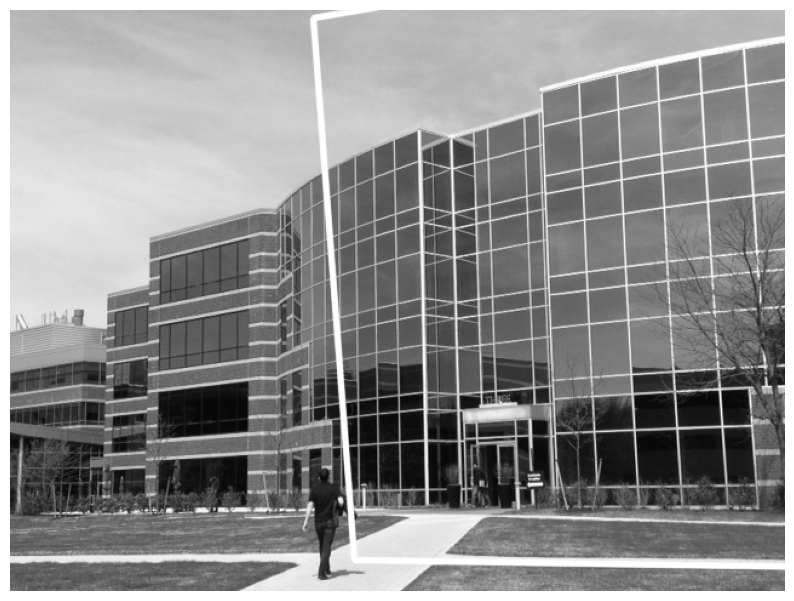

In [10]:
# Define a minimum number of good matches required for further processing
MIN_MATCH_COUNT = 10

# Check if the number of good matches is above the threshold
if len(good) > MIN_MATCH_COUNT:
    # Extract source and destination points from good matches
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # Find the homography matrix using RANSAC algorithm
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Get the height and width of the first image (img1)
    h, w = img1.shape

    # Define the four corners of the first image
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

    # Transform the corners using the homography matrix to get the corresponding corners in the second image
    dst = cv2.perspectiveTransform(pts, M)

    # Draw a polygon around the transformed corners on the second image
    img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

    # Display the second image with the polygon
    plt_show([img2])
else:
    # If there are not enough good matches, print a message
    print("Not Enough Matches are Found")

### Image Stitching and Perspective Transformation

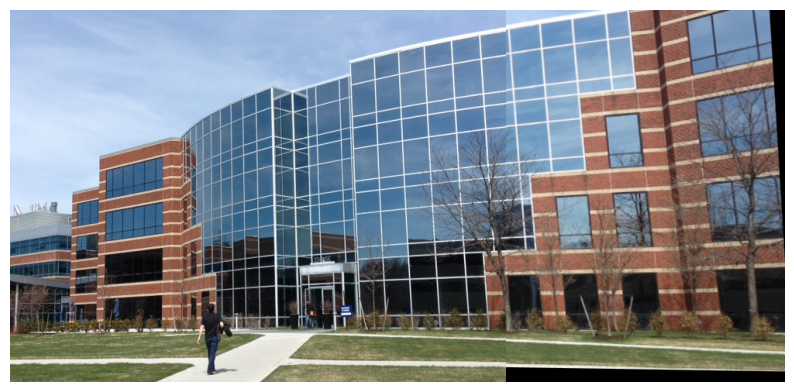

True

In [11]:
# Perform perspective transformation to stitch images using the homography matrix (M)
dst = cv2.warpPerspective(img_, M, (img.shape[1] + img_.shape[1], img.shape[0]))

# Overlay the original image onto the transformed space in the stitched result
dst[0:img.shape[0], 0:img.shape[1]] = img

# Display the stitched image (showing only the first 1000 columns for visibility)
plt_show([dst[:, 0:1000]])

# Save the stitched image to a file
cv2.imwrite("MyOutput2.png", dst[:, 0:1000])